In [ ]:
import argparse
import concurrent
from dotenv import load_dotenv
from tqdm import tqdm
import os,json,re,yaml
import textgrad as tg
from textgrad.tasks import load_task
import numpy as np
import random,json
import qadataset_dataloader as qadataset_dataloader
import torch

if os.path.isfile("api_key.yml"):
    with open("api_key.yml","r") as f:
        key=yaml.safe_load(f)

os.environ['OPENAI_API_KEY'] = key['openai']['api_key']


llm_api_eval = tg.get_engine(engine_name="gpt-4o")
llm_api_test = tg.get_engine(engine_name="gpt-3.5-turbo-0125")
tg.set_backward_engine(llm_api_eval, override=True)

# Initialize the system prompt
system_prompt = tg. Variable ("You are a helpful language model,Think step by step .",requires_grad = True ,role_description =" system prompt to the language model ")

# Set up the model object ’ parameterized by ’ the prompt .
model = tg. BlackboxLLM ( system_prompt = system_prompt )

# Optimize the system prompt
optimizer = tg. TextualGradientDescent ( parameters =[ system_prompt ])
for iteration in range (5):
    question_str="Which poisonous compound was used by a religous cult in deadly attacks on the Tokyo subway in 1995?"
    answer_str="sarin gas"

    batch_x = tg.Variable(question_str, role_description="question to the LLM", requires_grad=False)

    batch_y = tg.Variable(answer_str, role_description="answer to the question", requires_grad=False)

    optimizer . zero_grad ()
    # Do the forward pass
    responses = model (batch_x)
    losses = [ loss_fn ( response , y ) for ( response , y) in zip ( responses , batch_y ) ]
    total_loss = tg. sum( losses )
    # Perform the backward pass and compute gradients
    total_loss . backward ()
    # Update the system prompt
    optimizer . step ()

In [ ]:
import argparse
import concurrent
from dotenv import load_dotenv
from tqdm import tqdm
import os,json,re,yaml
import textgrad as tg
from textgrad.tasks import load_task
import numpy as np
import random,json


question_str="Which poisonous compound was used by a religous cult in deadly attacks on the Tokyo subway in 1995?"
answer_str="sarin gas"

class text_grad:
    def __init__(self) -> None:
        load_dotenv(override=True)
        llm_api_eval = tg.get_engine(engine_name="gpt-4o")
        llm_api_test = tg.get_engine(engine_name="gpt-3.5-turbo-0125")
        tg.set_backward_engine(llm_api_eval, override=True)
        train_set, val_set, test_set, self.eval_fn = load_task("BBH_word_sorting", evaluation_api=llm_api_eval)

        self.STARTING_SYSTEM_PROMPT="You will answer a reasoning question with confidence score. Think step by step. The last line of your response should be of the following format: 'Answer: $VALUE' where VALUE is the answer to the question"
        self.set_up_keys()

        self.system_prompt_eval = tg.Variable(self.STARTING_SYSTEM_PROMPT,
                            requires_grad=True,
                            role_description="system prompt to the language model")
        self.model_evaluation = tg.BlackboxLLM(llm_api_eval, self.system_prompt_eval)

        self.system_prompt = tg.Variable(self.STARTING_SYSTEM_PROMPT,
                                    requires_grad=True,
                                    role_description="structured system prompt to a somewhat capable language model that specifies the behavior and strategies for the QA task")
        self.model = tg.BlackboxLLM(llm_api_test, self.system_prompt)

        self.optimizer = tg.TextualGradientDescent(engine=llm_api_eval, parameters=[self.system_prompt])

    def set_up_keys(self):
        if os.path.isfile("api_key.yml"):
            with open("api_key.yml","r") as f:
                key=yaml.safe_load(f)

        os.environ['OPENAI_API_KEY'] = key['openai']['api_key']

    def generate(self,question_str,answer_str):

        self.optimizer.zero_grad()
        question = tg.Variable(question_str, role_description="question to the LLM", requires_grad=False)

        answer = tg.Variable(answer_str, role_description="answer to the question", requires_grad=False)
        prediction_origin = self.model(question)
        print(prediction_origin.__repr__())
        loss = self.eval_fn(inputs=dict(prediction=prediction_origin, ground_truth_answer=answer))
        loss.backward()
        self.optimizer.step()
        prediction_after = self.model(question)
        print(prediction_after.__repr__())
        result={
            "prompt_before":self.STARTING_SYSTEM_PROMPT,
            'prompt_after':self.system_prompt.value,
            'answer_before':prediction_origin.value,
            # 'grad_fn_before':prediction_origin.get_grad_fn(),
            'answer_after':prediction_after.value,
            "ground_truth":answer.value,
            # 'grad_fn_after':prediction_origin.get_grad_fn(),
        }
        return result

tt=text_grad()
result=tt.generate(question_str,answer_str)
with open('text.json','w') as f:
    json.dump(result,f,indent=4)

## TextGrad

In [ ]:
import argparse
import concurrent
from dotenv import load_dotenv
from tqdm import tqdm
import os,json,re,yaml
import textgrad as tg
from textgrad.tasks import load_task
import numpy as np
import random,json

class text_grad:
    def __init__(self) -> None:
        self.set_up_keys()
        tg.set_backward_engine("gpt-3.5-turbo-0125", override=True)

        # Step 1: Get an initial response from an LLM.
        self.model = tg.BlackboxLLM("gpt-4o")
    def set_up_keys(self):
        if os.path.isfile("api_key.yml"):
            with open("api_key.yml","r") as f:
                key=yaml.safe_load(f)

        os.environ['OPENAI_API_KEY'] = key['openai']['api_key']

    def parser(self,text):
        answer_match = re.search(r'"answer": "(.*?)"', text)
        if answer_match:
            answer = answer_match.group(1)
        # Regex to capture the confidence score
        confidence_match = re.search(r'"confidence": (\d+\.\d+)', text)
        if confidence_match:
            confidence_score = float(confidence_match.group(1))

        return {"Answer":answer,"Confidence":confidence_score}

    def text_grad_get_response(self,question_str,answer_str):

        question_string = (f"{question_str}"
                        "provide 'answer' to the question and 'confidence' to the answer in json,confidence is a float value between 0 and 1")

        question = tg.Variable(question_string,
                            role_description="question to the LLM",
                            requires_grad=False)

        answer = self.model(question)

        print(answer)
        result=self.parser(str(answer))

        answer.set_role_description("concise and accurate answer to the question")

        # Step 2: Define the loss function and the optimizer, just like in PyTorch!
        # Here, we don't have SGD, but we have TGD (Textual Gradient Descent)
        # that works with "textual gradients".
        optimizer = tg.TGD(parameters=[answer])
        evaluation_instruction = (f"Here's a question: {question_string}. "
                                "Evaluate any given answer to this question, "
                                "be smart, logical, and very critical. "
                                "Just provide concise feedback."
                                )
        # TextLoss is a natural-language specified loss function that describes
        # how we want to evaluate the reasoning.
        loss_fn = tg.TextLoss(evaluation_instruction)

        # Step 3: Do the loss computation, backward pass, and update the punchline.
        # Exact same syntax as PyTorch!
        loss = loss_fn(answer)
        loss.backward()
        optimizer.step()
        print(answer)
        result=self.parser(answer.value)

        return result

question_str="Who is the best golfer in the world?"
answer_str=""
result=text_grad().text_grad_get_response(question_str,answer_str)
print(result)


## Example of refinement

In [ ]:
import json
from random import randint
class demo:
    def __init__(self,path) -> None:
        with open(path,"r") as f:
            self.refine_data=json.load(f)

    def Get_original_result(self,Question):
        with open('CAPR/response_result/20240601/din0s_asqa_gpt-3.5-turbo-0125_vanilla_Long_QA.json','r') as af:
            self.origin_data=json.load(af)

        print(self.origin_data[0].keys())

        for i in self.origin_data:
            if i["Question"]==Question:
                self.result['origin_answer']=i["Answer"]
                self.result['origin_confidence']=i["Confidence"]
                self.result['origin_Instruction']=i['Prompt']["Instruction"]

    def Refine_exmple(self,api_model):
        temp_acc=0.1
        self.result={}
        data_size=len(self.refine_data[api_model]['Evaluate_result']['Accuracy'])
        print(f"{api_model} Data size {data_size}")
        idx=randint(0,data_size-1)
        for idx in range(data_size):
            if self.refine_data[api_model]['Example']['old_prompt'][idx]['Question']=="Question : When was the first apple i phone made?":
                # print(self.refine_data[api_model]['Example'].keys())
                self.result["Question"]=self.refine_data[api_model]['Example']['old_prompt'][idx]['Question']
                self.result["Origin_Instruction"]=self.refine_data[api_model]['Example']['old_prompt'][idx]['Instruction']
                self.result["After_Instruction"]=self.refine_data[api_model]['Example']['new_prompt'][idx]['Instruction']
                self.result["Ground_truth"]=self.refine_data[api_model]['Example']['Ground_truth'][idx]
                self.result['origin_answer']=self.refine_data[api_model]['Example']['old_Result'][idx]['Answer']
                self.result['origin_Verbal_Confidence']=self.refine_data[api_model]['Example']['old_Result'][idx]['Confidence']
                self.result['CAPR_answer']=self.refine_data[api_model]['Example']['Result'][idx]['Answer']
                self.result['CAPR_Verbal_Confidence']=self.refine_data[api_model]['Example']['Result'][idx]['Confidence']
                self.result['Accuracy']=self.refine_data[api_model]['Evaluate_result']['Accuracy'][idx]
                self.result['old_Accuracy']=self.refine_data[api_model]['Evaluate_result']['old_Accuracy'][idx]
                self.result['Pace_Conf']=self.refine_data[api_model]['Evaluate_result']['Pace_Conf'][idx]
                self.result['old_Pace_Conf']=self.refine_data[api_model]['Evaluate_result']['old_Pace_Conf'][idx]

    def retrieve_example(self,api_model):
        self.Refine_exmple(api_model)
        with open(f"{api_model}_Example.json",'w+') as f:
            json.dump(self.result,f,indent=4)

        # for k,v in self.result.items():
            # print(k)
            # print(f"\t{v}")

dd=demo('CAPR/Inf_din0s_asqa_r12_withPACE.json',)
dd.retrieve_example("gpt-4-turbo")
dd.retrieve_example("gpt-3.5-turbo-0125")
dd.retrieve_example("claude-3-5-sonnet-20240620")


## Moveing Average of RL

In [ ]:
import json,os
import matplotlib.pyplot as plt


def Moving_average(data_folder):
    data_size=20
    ratio=0.99
    for k in ['reward','Accuracy','ECE']:
        data_path=f'{data_folder}/{k}.json'
        if os.path.isfile(data_path):
            with open(data_path,'r') as f:
                data=json.load(f)
            movin_avg=sum(data[:data_size])/data_size
            k1=[]
            for i in data:
                movin_avg=ratio*movin_avg+(1-ratio)*i
                k1.append(movin_avg)

            plt.plot(range(len(k1)),k1,label=k,marker='')
            plt.legend()
            plt.savefig(f"{data_path.replace(".json","mvavg.png")}")
            plt.show()
            plt.clf()

Moving_average("CAPR/PPO_State_06122032_vanilla_f1_r1_trivia_withPACE")


In [ ]:
import torch
from netcal.metrics import ECE
from torch import rand
import numpy as np
def get_ece(y_confs,y_true):
    y_confs=np.array([i.item() for i in y_confs])
    y_true=np.array([i.item() for i in y_true])
    accuracy = np.mean(y_true)
    # y_true=np.where(y_true < accuracy,0,1) ## change to binary ## init 0.59
    # ECE
    n_bins = 10
    # diagram = ReliabilityDiagram(n_bins)
    ece = ECE(n_bins)
    ece_score = ece.measure(y_confs, y_true)
    # print("ECE:", ece_score)
    return torch.tensor(ece_score)

y_true=rand(size=(128,))/10+0.5
y_conf=rand(size=(128,))/10+0.8

ece=torch.abs(y_true-y_conf)
print(-torch.mean(ece))


## Rouge

In [ ]:
from rouge_score import rouge_scorer
import evaluate
def calculate_rouge(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    print(scores)
    return scores['rougeL'].fmeasure



# Example usage
reference = ["The cat sat on the mat."]
hypothesis = ["The cat sat in the rain"]
scores = [calculate_rouge(i,j) for i,j in zip(reference, hypothesis)]
print(scores)


# rouge=evaluate.load('rouge')

# rouge_results=[rouge.compute(predictiopni,j) for i,j in zip(hypothesis,reference)]
# print(rouge_results)
# print(rouge_results['rougeL'])
# print((rouge_results['rougeL'] > 0.3).astype('int')

In [ ]:
from transformers import AutoModel
model = AutoModel.from_pretrained("microsoft/deberta-large")

## ROC CURVE

In [ ]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt
def Getfig(fpr,tpr,auc,data_name):
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(f"picture/{data_name}_roc_curve.png")
    # plt.show()
    plt.clf()


def aur_trail(activate_time,shuffle):
    isshuffle_str="shuffle" if shuffle else "No_shuffle"
    datapaht=f"./PACE/response_result/Evaluate_Result_{activate_time}_{isshuffle_str}.json"
    with open(datapaht,'r') as f:
        data=json.load(f)
    simi_models=["Cos_sim"]
    datasets=["triviaQA"]
    api_model='gpt-3.5-turbo-0125'
    acc_model='bool_acc'
    stretagy=["vanilla",'cot',"multi_step"]

    for sim in simi_models:
        for dataset in datasets:
            for dd in data:
                for k in stretagy:
                    # conf_list,Final_conf_list,simi_list,acc_list=[],[],[],[]
                    if dd['dataset']==dataset and dd['sim_model']==sim and dd['Stratagy']==k and dd['acc_model']==acc_model and dd['api_model']==api_model:
                        print("*"*100)
                        print(f"Load Sucess {dataset} {k} {sim} {acc_model}")
                        acc=np.array(dd['Accuracy'])
                        accurate=np.where(acc < 0.55,0,1)
                        score1=np.array(dd['Conf'])
                        score2=np.array(dd['Pace_Conf'])
                        fpr1, tpr1, thresholds1 = roc_curve(accurate, score1)
                        fpr2, tpr2, thresholds2 = roc_curve(accurate, score2)
                        auc1=auc(fpr1, tpr1)
                        auc2=auc(fpr2, tpr2)
                        print(np.mean(accurate))
                        print(np.mean(score2))
                        # print(score2)
                        print(auc1,auc2)
                        Getfig(fpr1,tpr1,auc1,f"{dataset}")
                        Getfig(fpr2,tpr2,auc2,dataset)

aur_trail(activate_time="20240601",shuffle=False)

## GET PACE Result

In [ ]:
from sklearn.metrics import roc_auc_score
def Print_data(activate_time,shuffle):
    isshuffle_str="shuffle" if shuffle else "No_shuffle"
    datapaht=f"./PACE/response_result/Evaluate_Result_{activate_time}_{isshuffle_str}.json"
    with open(datapaht,'r') as f:
        data=json.load(f)
    simi_models=["Cos_sim"]
    datasets=["triviaQA"]
    api_model='claude-3-5-sonnet-20240620'
    acc_model='bool_acc'
    stretagy=["vanilla",'cot',"multi_step"]

    for sim in simi_models:
        for dataset in datasets:
            for dd in data:
                for k in stretagy:
                    # conf_list,Final_conf_list,simi_list,acc_list=[],[],[],[]
                    if dd['dataset']==dataset and dd['sim_model']==sim and dd['Stratagy']==k and dd['acc_model']==acc_model and dd['api_model']==api_model:
                        print("*"*100)
                        print(f"Load Sucess {dataset} {k} {sim} {acc_model}")
                        print(f"Accuracy {np.mean(np.array(dd['Accuracy']))}")
                        print(f"ECE {np.mean(np.array(dd['ece']))}")
                        print(f"ECE after {np.mean(np.array(dd['ece_pace']))}")
                        print(f"AUROC {np.mean(np.array(dd['auroc']))}")
                        print(f"AUROC after {np.mean(np.array(dd['auroc_pace']))}")
                        # print("*"*100)
Print_data(activate_time="20240601",shuffle=False)


## Get Fig

Load Sucess din0s/asqa vanilla Cos_sim
[0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975]
[0.8525 0.8575 0.8625 0.8675 0.8725 0.8775 0.8825 0.8875 0.8925 0.8975
 0.9025 0.9075 0.9125 0.9175 0.9225 0.9275 0.9325 0.9375 0.9425 0.9475]


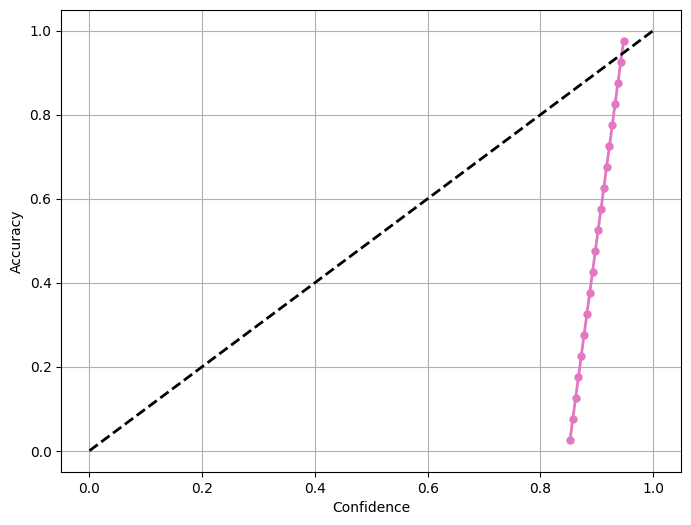

****************************************************************************************************
[0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975]
[0.59874352 0.61710162 0.63545972 0.65381782 0.67217591 0.69053401
 0.70889211 0.72725021 0.74560831 0.76396641 0.78232451 0.80068261
 0.81904071 0.83739881 0.85575691 0.87411501 0.89247311 0.91083121
 0.92918931 0.94754741]


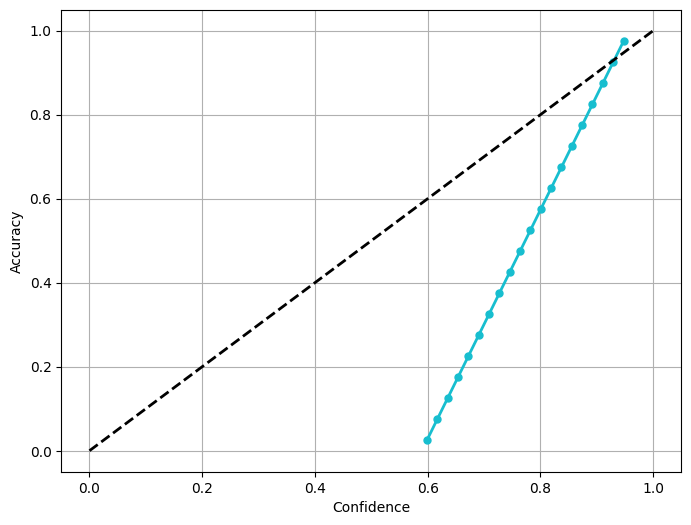

Load Sucess triviaQA vanilla Cos_sim
[0.22311896 0.26295906 0.30279917 0.34263927 0.38247937 0.42231947
 0.46215957 0.50199968 0.54183978 0.58167988 0.62151998 0.66136009
 0.70120019 0.74104029 0.78088039 0.82072049 0.8605606  0.9004007
 0.9402408  0.9800809 ]
[0.1225 0.1675 0.2125 0.2575 0.3025 0.3475 0.3925 0.4375 0.4825 0.5275
 0.5725 0.6175 0.6625 0.7075 0.7525 0.7975 0.8425 0.8875 0.9325 0.9775]


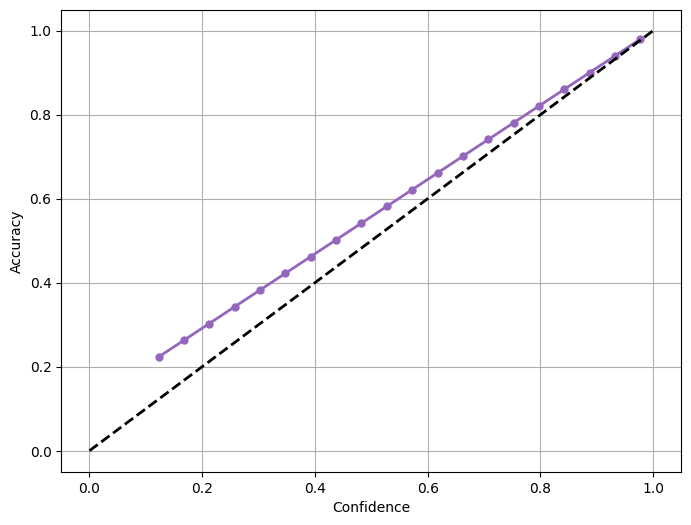

****************************************************************************************************
[0.22311896 0.26295906 0.30279917 0.34263927 0.38247937 0.42231947
 0.46215957 0.50199968 0.54183978 0.58167988 0.62151998 0.66136009
 0.70120019 0.74104029 0.78088039 0.82072049 0.8605606  0.9004007
 0.9402408  0.9800809 ]
[0.15742432 0.20063333 0.24384234 0.28705135 0.33026036 0.37346936
 0.41667837 0.45988738 0.50309639 0.5463054  0.58951441 0.63272342
 0.67593243 0.71914144 0.76235045 0.80555946 0.84876847 0.89197748
 0.93518649 0.9783955 ]


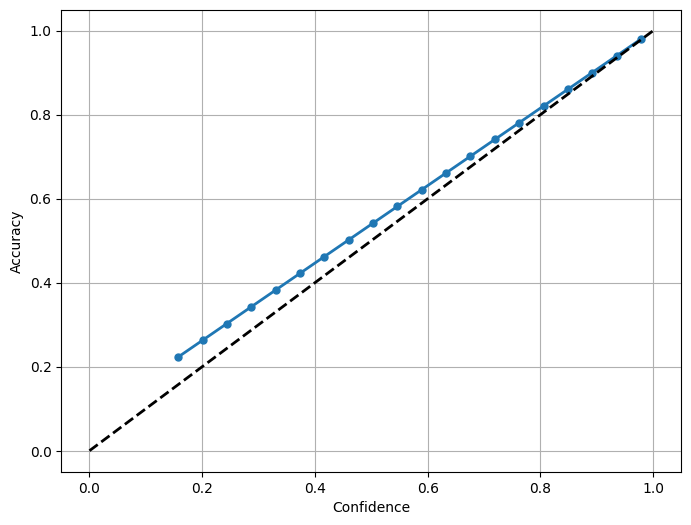

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import json,random,os

# datapath="response_result/20240517/din0s_asqa_gpt-3.5-turbo-0125_cot_Long_QA_gpt-3.5-turbo-0125_bertscore.json"

def get_datapath(dataset,api_model,activate_time,acc_model,sim_model,prompt_strategy,isshuffle_str)-> list:
    task=["QA","Long_QA"]
    datapath=[]
    for i in prompt_strategy:
        for t in task:
            path=f"response_result/{activate_time}/{dataset}_{api_model}_{i}_{t}_{sim_model}_{acc_model}_{isshuffle_str}.json"
            print(path)
            if os.path.isfile(path):
                datapath.append(path)

    return datapath

def mean(data):
    return sum(data)/len(data)

def Load_data(datapath):
    with open(datapath,'r') as f:
        data=json.load(f)

    conf=[i['Confidence'] for i in data]
    ## MAX
    simi=[max(map(float,i['Doc_Ans_simi'])) for i in data]
    ## Mean
    mean_simi=[sum(map(float,i['Doc_Ans_simi']))/len(i['Doc_Ans_simi']) for i in data]
    acc=[i['Accuracy'] for i in data]
    assert len(simi)==len(conf)
    return [conf,mean_simi,acc]

# color=['lightblue','lightred',"lightgreen","yellow",'pink','lightbrown']
def Get_histogram(datalist,dataset,title,stretagy):
# Generate sample data
    # data1 = np.random.normal(0, 1, 1000)
    plt.figure(figsize=(4, 3))
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    # assert len(lable)==len(datalist)
    # Plot histograms
    for idx,i in enumerate(datalist):
        plt.hist(i, bins=100, alpha=0.7, label=stretagy[idx],color=colors[idx% len(colors)])
    # Adding labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f"{dataset}_{title}")
    plt.legend(loc='upper right')
    plt.xlim([0, 1])
    # plt.ylim([0, 600])
    # Show the plot
    plt.savefig(f"picture/histogram/{dataset}_{title}.png")
    # plt.show()
    plt.clf

def show_histogram_graph(vector,title,File_name,stretagy="",sim="",datafile_name="",label=[]):
    os.makedirs(f"PACE/picture/histogram/{File_name}",exist_ok=True)
    # Plot histogram
    plt.figure(figsize=(4, 3))
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    random.shuffle(colors)
    for i,j in zip(vector,label):
        plt.hist(i, bins=100, density=True, alpha=0.7, color=colors[random.randint(0,len(colors)-1)], edgecolor='black',label=j)
    # Add a title and labels
    plt.title(f'{title}')
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    # plt.ylim(0,1)
    plt.xlim(0,1)
    # Add a grid
    plt.grid(True)
    plt.legend(loc='upper right')
    # Show plot
    plt.savefig(f"PACE/picture/histogram/{File_name}/{datafile_name}.png")
    # plt.show()
    plt.clf

def show_plot_graph(vector,File_name,datafile_name="",label=""):
    os.makedirs(f"PACE/picture/histogram/{File_name}",exist_ok=True)
    # Plot histogram
    plt.figure(figsize=(6, 3),facecolor='none')
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    random.shuffle(colors)
    ## len(vector)//5
    counts, bin_edges = np.histogram(vector, bins=10)
    plt.gca().set_facecolor(None)
    # 計算每個柱的中心點
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # plt.hist(vector, bins=30, alpha=0.3, color='gray', edgecolor='black')
    plt.plot(bin_centers,counts, marker='',linestyle='-', color=colors[random.randint(0,len(colors)-1)],label=label,linewidth=3)
    # Add a grid
    # plt.grid(True)
    plt.xlim(0,1)
    plt.legend(loc='upper left', fontsize=10)
    # Show plot
    plt.savefig(f"PACE/picture/histogram/{File_name}/{datafile_name}.png",transparent=True)
    # plt.show()
    plt.clf

def acc_conf_plot(accuracy,Confidence,File_name,dataset,stretagy):
    histogram_bin=20
    os.makedirs(f"PACE/picture/histogram/{File_name}",exist_ok=True)
    # Plot histogram
    plt.figure(figsize=(8, 6),facecolor='none')
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    random.shuffle(colors)

    acc_counts, acc_bin_edges = np.histogram(accuracy, bins=histogram_bin)
    acc_bin_centers = (acc_bin_edges[:-1] + acc_bin_edges[1:]) / 2
    # print(acc_counts)
    # print(acc_bin_edges)
    print(acc_bin_centers)

    conf_counts, conf_bin_edges = np.histogram(Confidence, bins=histogram_bin)
    conf_bin_centers = (conf_bin_edges[:-1] + conf_bin_edges[1:]) / 2
    # print(conf_counts)
    # print(conf_bin_edges)
    print(conf_bin_centers)
    # plt.gca().set_facecolor(None)
    # 計算每個柱的中心點
    # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # plt.hist(vector, bins=30, alpha=0.3, color='gray', edgecolor='black')
    plt.plot(conf_bin_centers,acc_bin_centers, marker='.',linestyle='-', color=colors[random.randint(0,len(colors)-1)],linewidth=2,markersize=10)
    plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--', color='black', linewidth=2)

    plt.grid(True)
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
        # Set x and y axis titles
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    # plt.legend(loc='upper left', fontsize=10)
    # Show plot
    # plt.savefig(f"PACE/picture/histogram/{File_name}/{datafile_name}.png",transparent=True)
    plt.show()
    plt.clf

def Update_Fig(activate_time,shuffle):
    isshuffle_str="shuffle" if shuffle else "No_shuffle"
    datapaht=f"./PACE/response_result/Evaluate_Result_{activate_time}_{isshuffle_str}.json"
    with open(datapaht,'r') as f:
        data=json.load(f)

    os.makedirs("PACE/picture/histogram",exist_ok=True)
    simi_models=["Cos_sim"]
    datasets=["din0s/asqa","triviaQA"]
    api_model='gpt-3.5-turbo-0125'

    acc_mapping={"din0s/asqa":"rougeL","triviaQA":"f1"}

    # stretagy=["vanilla",'cot',"multi_step"]
    stretagy=["vanilla"]

    for sim in simi_models:
        for dataset in datasets:
            for dd in data:
                for k in stretagy:
                    # conf_list,Final_conf_list,simi_list,acc_list=[],[],[],[]
                    if dd['dataset']==dataset and dd['sim_model']==sim and dd['Stratagy']==k and dd['acc_model']==acc_mapping[dataset] and api_model==dd['api_model']:
                        dataset_path=dataset.replace("/","_")
                        print(f"Load Sucess {dataset} {k} {sim}")
                        # print(f"Accuracy {np.mean(np.array(dd['Accuracy']))}")
                        # print(f"ECE {np.mean(np.array(dd['ece']))}")
                        # print(f"AUROC {np.mean(np.array(dd['auroc']))}")
                        # print(dd['Simi'])
                        ### Show plot Figure
                        # show_plot_graph(dd['Conf'],File_name=f"{activate_time}_{isshuffle_str}",stretagy=k,sim=f"{sim}",datafile_name=f"{dataset_path}_{isshuffle_str}_{sim}_{k}_Confidence",label=f"Confidence")

                        # show_plot_graph(dd['Simi'],File_name=f"{activate_time}_{isshuffle_str}",stretagy=k,sim=f"{sim}",datafile_name=f"{dataset_path}_{isshuffle_str}_{sim}_{k}_Similarity",label=f"Similarity")

                        # show_plot_graph(dd['Pace_Conf'],File_name=f"{activate_time}_{isshuffle_str}",stretagy=k,sim=f"{sim}",datafile_name=f"{dataset_path}_{isshuffle_str}_{sim}_{k}_PACE_Confidence",label=f"PACE Confidence")

                        # show_plot_graph(dd['Accuracy'],File_name=f"{activate_time}_{isshuffle_str}",stretagy=k,sim=f"{sim}",datafile_name=f"{dataset_path}_{isshuffle_str}_{sim}_{k}_Accuracy",label=f"Accuracy")

                        ### Show Accuracy and Confidence figure
                        acc_conf_plot(dd['Accuracy'],dd['Conf'],File_name=f"{activate_time}_{isshuffle_str}",dataset=dataset_path,stretagy=k)
                        print("*"*100)
                        acc_conf_plot(dd['Accuracy'],dd['Pace_Conf'],File_name=f"{activate_time}_{isshuffle_str}",dataset=dataset_path,stretagy=k)

Update_Fig("20240601",False)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json,random,os

def show_four_plot(vectorlist,title):
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    random.shuffle(colors)
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    fig.patch.set_facecolor('lightgrey')
    # Plot each vector list in its respective subplot
    for i, ax in enumerate(axs.flat):
        counts, bin_edges = np.histogram(vectorlist[i], bins=len(vectorlist[i])//10)
        # 計算每個柱的中心點
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # plt.hist(vector, bins=30, alpha=0.3, color='gray', edgecolor='black')

        ax.plot(bin_centers,counts, marker='.',linestyle='-', color=colors[random.randint(0,len(colors)-1)],label='No Shuffle')
        # ax.set_xlabel('Index')
        if i%2:
            ax.set_ylabel('Accuracy',fontsize=12)
        else:
            ax.set_ylabel('Confidence',fontsize=12)
        ax.set_xlim((0,1))
        ax.set_facecolor('whitesmoke')
    # fig.suptitle(title, fontsize=16)
    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 1, 1])

    # Show the plot
    plt.show()
    plt.clf()

def Update_Fig(activate_time,shuffle):
    isshuffle_str="shuffle" if shuffle else "No_shuffle"
    datapaht=f"./PACE/response_result/Evaluate_Result_{activate_time}_{isshuffle_str}.json"
    with open(datapaht,'r') as f:
        data=json.load(f)

    os.makedirs("PACE/picture/histogram",exist_ok=True)
    simi_models=["Cos_sim"]
    datasets=["din0s/asqa"]
    api_model='gpt-3.5-turbo-0125'
    acc_model='rougeL'

    stretagy=["vanilla",'cot',"multi_step"]
    vector=[]
    for sim in simi_models:
        for dataset in datasets:
            for dd in data:
                for k in stretagy:
                    # conf_list,Final_conf_list,simi_list,acc_list=[],[],[],[]
                    if dd['dataset']==dataset and dd['sim_model']==sim and dd['Stratagy']==k and dd['acc_model']==acc_model:
                        vector+=[dd['Conf'],dd['Accuracy']]
                        show_four_plot([dd['Conf'],dd['Accuracy']],k)

Update_Fig(20240601,False)

In [ ]:
def show_histogram_graph(vector,dim_x_y,stretagy=""):
    # Plot histogram
    plt.figure(figsize=(4, 3))
    plt.hist(vector, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
    # Add a title and labels
    plt.title(f'{stretagy} Score')
    plt.xlabel('Confidence Value')
    plt.ylabel('Density')
    # plt.ylim(0,1)
    plt.xlim(0,1)
    # Add a grid
    plt.grid(True)

    # Show plot
    # plt.savefig(f"picture/histogram/{dataset}_{title}.png")
    plt.show()
    plt.clf

from netcal.metrics import ECE

activate_time="20240529"

os.makedirs("picture/histogram",exist_ok=True)
simi_models=["Cos_sim","snli"]
datasets=["natural_questions",'din0s_asqa']
api_model='gpt-3.5-turbo-0125'
acc_model='bertscore'

stretagy=["vanilla",'cot',"multi_step"]

simi_model="snli"
dataset="din0s_asqa"

path_list=get_datapath(dataset=dataset,api_model=api_model,activate_time=activate_time,acc_model=acc_model,sim_model=simi_model,prompt_strategy=stretagy)

evaldata=list(map(Load_data,path_list))

for k in range(3):
    accuracy=np.mean(np.array(evaldata[k][2]))
    y_confs=evaldata[k][0]
    y_true=list(map(float,evaldata[k][2]))
    y_true=np.where(np.array(y_true) < 0.9,0,1)

    ll=0.5
    pace_conf_array = np.add(ll*np.array(evaldata[k][0]),(1-ll)*np.array(evaldata[k][1]))

    # ECE
    n_bins = 10
    # diagram = ReliabilityDiagram(n_bins)
    ece = ECE(n_bins)
    assert len(y_confs)==len(y_true)
    ece_score = ece.measure(np.array(y_confs), np.array(y_true),uncertainty='mean')
    print("ECE:", ece_score)

    n_bins = 10
    # diagram = ReliabilityDiagram(n_bins)
    ece = ECE(n_bins)
    ece_pace_score = ece.measure(pace_conf_array, np.array(y_true))
    print("ECE_PACE:", ece_pace_score)

    print(f"conf origin {np.mean(y_confs)}, PACE {np.mean(pace_conf_array)}")

    show_histogram_graph(y_confs,dim_x_y=[0,1],stretagy=f"{simi_model}")

    show_histogram_graph(evaldata[k][1],dim_x_y=[0,1],stretagy=f"{simi_model}")

    show_histogram_graph(pace_conf_array,dim_x_y=[0,1],stretagy=f"{simi_model}")

    # show_histogram_graph(y_true,dim_x_y=[0,1],stretagy=f"{simi_model}")

In [ ]:
from transformers import BertTokenizer

def split_text_into_fixed_length_parts(text, tokens_per_part, model_name='bert'):

    model_huggingface={
        'bert':'bert-base-uncased',
        'xbert':'efederici/sentence-bert-base',
    }

    # Initialize the tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_huggingface[model_name])

    # Tokenize the text
    tokens = tokenizer.tokenize(text)

    # Initialize the list to hold each part
    parts = []

    # Calculate the number of full parts
    full_parts = len(tokens) // tokens_per_part

    # Create parts with exactly tokens_per_part tokens
    for i in range(full_parts):
        start_index = i * tokens_per_part
        end_index = start_index + tokens_per_part
        part_tokens = tokens[start_index:end_index]
        # Convert token list to string and add to the parts list
        parts.append(tokenizer.convert_tokens_to_string(part_tokens))

    # Handle the remaining tokens, if any
    if len(tokens) % tokens_per_part:
        remaining_tokens = tokens[full_parts * tokens_per_part:]
        parts.append(tokenizer.convert_tokens_to_string(remaining_tokens))

    return parts

# Example usage
text = "Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face."
tokens_per_part = 96
result = split_text_into_fixed_length_parts(text, tokens_per_part,'bert')
result = split_text_into_fixed_length_parts(text, tokens_per_part,'xbert')


## ACC

In [ ]:
import json
from tokenizers.normalizers import BertNormalizer
from evaluate import load
def load_data():
    with open('/home/thesis/confidence_Score/response_result/gpt-3.5-turbo-0125_vanilla_simi_2024_05_08.json','r') as f:
        data=json.load(f)
    # print(data.keys())
    simi_res=data['When did the kokoda war start and end?']['similarity_res']
    olddat=simi_res[0]
    for i in simi_res:
        if i[1] > olddat[1]:
            olddat=i
    ans,long_ans=olddat[2],olddat[3]
    return ans,long_ans
def Bernormalize(ans,long_ans):
    nomalizer=BertNormalizer(clean_text=True,lowercase=True,handle_chinese_chars=True)
    return nomalizer.normalize_str(ans),nomalizer.normalize_str(long_ans)

### WER metric

In [ ]:
ans,long_ans=load_data()
print(ans)
print(long_ans)
wer_metric = load("wer")
acc_wer = wer_metric.compute(references=[ans], predictions=[long_ans])
print(f"WER acc : {acc_wer}")
print(f"1- WER acc : {1-acc_wer}")

### EM Score

In [ ]:
ans,long_ans=load_data()
print(ans)
print(long_ans)
exact_match_metric = load("exact_match")
results = exact_match_metric.compute(predictions=[ans], references=[long_ans])
print(results['exact_match'])

### Semantic similarity

In [ ]:
from sentence_transformers import SentenceTransformer, util
ans,long_ans=load_data()

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#Compute embedding for both lists
embedding_1= model.encode(ans, convert_to_tensor=True)
embedding_2 = model.encode(long_ans, convert_to_tensor=True)

result=util.pytorch_cos_sim(embedding_1, embedding_2)

print(result.item())
## tensor([[0.6003]])

### Bert Score

In [ ]:
from bert_score import score
from evaluate import load
ans,long_ans=load_data()
print(ans)
print(long_ans)


P, R, F1 = score([ans], [long_ans],lang="en",verbose=True)
# Print scores
print("Precision: ", P.item())
print("Recall: ", R.item())
print("F1 Score: ", F1.item())


bertscore = load("bertscore")
result=bertscore.compute(predictions=[ans],references=[long_ans],lang='en',verbose=True)
print("Precision: ", result['precision'].pop())
print("Recall: ", result['recall'].pop())
print("F1 Score: ", result['f1'].pop())

### Load data

In [ ]:
from util import load_checkpoint
import numpy as np
from torch.utils.data import DataLoader, Dataset, Sampler
datapath=f'response_result/gpt-3.5-turbo-0125_vanilla_2024_05_09.json'
datadict=load_checkpoint(datapath)

class eval_dataloader:
    def __init__(self,dataset_path,batch_size=1,purpose='eval') -> None:
        self.dataset = load_checkpoint(dataset_path)
        if purpose=="eval":
            self.loader=DataLoader(list(self.dataset.values()),batch_size=batch_size,collate_fn=self.simi_acc_collate_fn,shuffle=True)
        elif purpose=="ece":
            self.loader=DataLoader(list(self.dataset.values()),batch_size=batch_size,collate_fn=self.ece_collate_fn,shuffle=False)

    def simi_acc_collate_fn(self,batch):
        res=[]
        for i in batch:
            res.append([i['Question'],i['Document'],i['Answer'],i['Long Answer'],i['Confidence']])
        return res

    def ece_collate_fn(self,batch):
        simi_res=[]
        conf_res=[]
        accres=[]
        for i in batch:
            simi_res.append(i['similarity_res'])
            conf_res.append(i['confidence'])
            accres.append(i['acc'])
        return simi_res,conf_res,accres


def conf_calibration(simi,conf):
    x_lambda=0.5
    return x_lambda*simi+(1-x_lambda)*conf

def ece_calibration(simi:list,acc:list,conf:list): # batch b_m
    conf=list(map(conf_calibration,simi,conf))
    assert len(acc)==len(simi)
    b_m=len(acc)
    ece=np.mean(np.array(acc)-np.array(conf))/b_m
    return ece

def get_most_high_simi(simi_res:list):
    return sorted(simi_res,key=lambda x:x[1],reverse=True)[0][1]

eve_l=eval_dataloader(datapath,2,'eval').loader
print(len(eve_l))
# for simi_res,conf_res,accres in eve_l:
    # most_simi=list(map(get_most_high_simi,simi_res))
    # print(ece_calibration(most_simi,accres,conf_res))


In [ ]:
import torch
from sklearn.metrics import f1_score
from collections import Counter

def compute_macro_f1(sentence1, sentence2):
    # Tokenize the sentences
    tokens1 = sentence1.split()
    tokens2 = sentence2.split()

    # Count the frequency of each token in both sentences
    counter1 = Counter(tokens1)
    counter2 = Counter(tokens2)

    # Create a union of all unique tokens
    all_tokens = list(set(tokens1) | set(tokens2))

    # Create binary vectors for comparison
    vector1 = torch.tensor([counter1[token] for token in all_tokens])
    vector2 = torch.tensor([counter2[token] for token in all_tokens])

    # Compute the macro-F1 score
    f1 = torch.tensor(f1_score(vector1.numpy(), vector2.numpy(), average='macro'),dtype=torch.float16)

    return f1

# Example sentences
sentence1 = "The quick brown fox jumps over the lazy dog"
sentence2 = "A quick brown fox jumps over the lazy dog"

macro_f1 = compute_macro_f1(sentence1, sentence2)
print("Macro F1 Score:", macro_f1)


## Money Spent on API

In [ ]:
import os,glob
from util import load_checkpoint
def Calulate_spent(file_path='response_result/gpt-3.5-turbo-0125',api_model="gpt-3.5-turbo-0125"):
    compete_toekn=0
    prompt_token=0

    for datapath in glob.glob(f'{file_path}*.json'):
        if os.path.isfile(datapath):
            datares=load_checkpoint(datapath)
            print(f"{datapath} {len(datares)}")
            for i in datares.values():
                if "Complete_tokens" in i:
                    compete_toekn+=i['Complete_tokens']
                if "Prompt_tokens" in i:
                    prompt_token+=i['Prompt_tokens']

    Total_Spent =compete_toekn*8.00/1000000+prompt_token*6.00/1000000
    print(f"Complete tokens :{compete_toekn},prompt_tokens :{prompt_token} ")
    print(f"Total Spent {Total_Spent} USD ; {Total_Spent*30} TWD")


Calulate_spent()

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

def get_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

def is_answer_correct(question, true_answer, predicted_answer):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    # Get embeddings
    true_embedding = get_embedding(true_answer, model, tokenizer)
    predicted_embedding = get_embedding(predicted_answer, model, tokenizer)

    # Compute cosine similarity
    similarity = cosine_similarity(true_embedding.numpy(), predicted_embedding.numpy())[0][0]

    # Threshold for correctness
    threshold = 0.8
    print(similarity)
    return similarity >= threshold

# Example question and answers
question = "What is the capital of France?"
true_answer = "The capital of France is Paris."
predicted_answer = "Paris is the capital of France."

is_correct = is_answer_correct(question, true_answer, predicted_answer)
print("Is the answer correct?", is_correct)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def tokenize_sentences(text):
    # Simple sentence tokenizer (could be improved with more sophisticated methods)
    return text.split('. ')

def evaluate_long_form_qa(true_answer, predicted_answer):
    # Tokenize the answers into sentences
    true_sentences = tokenize_sentences(true_answer)
    predicted_sentences = tokenize_sentences(predicted_answer)

    # Generate binary labels
    true_labels = [1] * len(true_sentences)  # Assume all sentences in the ground truth are correct
    predicted_labels = [1 if sentence in true_sentences else 0 for sentence in predicted_sentences]

    # Calculate precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return precision, recall, f1

# Example long-form answers
true_answer = "The quick brown fox jumps over the lazy dog. Foxes are known for their agility. Dogs can be quite lazy at times."
predicted_answer = "The quick brown fox jumps over the lazy dog. Foxes are very agile animals. Sometimes dogs are lazy."

precision, recall, f1 = evaluate_long_form_qa(true_answer, predicted_answer)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


In [ ]:
from bert_score import BERTScorer
from sklearn.metrics import precision_score, recall_score, f1_score
eval_model = BERTScorer(
                        model_type="bert-base-uncased",  # Model type
                        num_layers=9,  # Number of layers to use
                        all_layers=False,  # Whether to use all layers
                        idf=False,  # Whether to use IDF scaling
                        batch_size=64,  # Batch size
                        lang=None,  # Language of the texts, auto-detect based on model if None
                        rescale_with_baseline=False,  # Whether to rescale
                        device='cuda:1'
                    )
def tokenize_sentences(text):
    # Simple sentence tokenizer (could be improved with more sophisticated methods)
    return text.split('. ')
true_answer = "The quick brown fox jumps over the lazy dog. Foxes are known for their agility. Dogs can be quite lazy at times."
predicted_answer = "The quick brown fox. The quick brown fox. The quick brown fox."

true_sentences=tokenize_sentences(true_answer)
predicted_sentences=tokenize_sentences(predicted_answer)
true_labels = [1] * len(true_sentences)  # Assume all sentences in the ground truth are correct
predicted_labels = [1 if sentence in true_sentences else 0 for sentence in predicted_sentences]
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
print(precision)
print(recall)
print(f1)


## Check Data

In [ ]:
import json
conf_path='response_result/gpt-3.5-turbo-0125_vanilla_2024_05_09.json'
simi_acc_path='response_result/gpt-3.5-turbo-0125_vanilla_simi_acc_2024_05_09.json'
with open(simi_acc_path,'r') as f:
    data1=json.load(f)
    print(len(data1))
    for i in data1.keys():
        print(i)

with open(conf_path,'r') as f:
    data2=json.load(f)
    print(len(data2))

In [ ]:
import glob
def show(conf_list):
    if isinstance(conf_list,dict):
        print(f"Evaluate Result:")
        for v in conf_list.values():
            print(f"      {v['Stratagy']}:")
            for k1,v1 in v.items():
                print(f"        {k1} : {v1}")
    elif isinstance(conf_list,list):
        print(f"Evaluate Result:")
        for v in conf_list:
            print(f"      {v['Stratagy']}:")
            for k1,v1 in v.items():
                print(f"        {k1} : {v1}")

for i in glob.glob("response_result/*_eval_*.json"):
    with open(i,'r') as f:
        show(json.load(f))


In [ ]:
import torch

a =[torch.tensor(i/100) for i in range(0,100)]
print(a)
print(torch.stack(a,dim=0))
# print(torch.mean())